In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [13]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/DL/faces94', transform=transform)
print(len(dataset))
# print(dataset[0])

3059


In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
print(len(dataloader))

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

96
cuda


In [0]:
def weights_init(modal):
    classname = modal.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(modal.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(modal.weight.data, 1.0, 0.02)
        nn.init.constant_(modal.bias.data, 0)


In [0]:
import csv
csvFile = open('/content/drive/My Drive/DL/AutoEncoder02.csv', 'a')
classes = {0:"female", 1:"male", 2:"malestaff"}

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 5, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            nn.Conv2d(8, 16, 5, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.Conv2d(16, 32, 5, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32, 64, 5, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 100, 4, 2),
            nn.BatchNorm2d(100),
            nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(100, 64, 4),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 6, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 16, 6, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 8, 7, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(8, 3, 8, 2),
            nn.BatchNorm2d(3),
            nn.ReLU(True),
        )
    
    def forward(self, input):
        out = self.encoder(input)
#         print("Features..")
        return self.decoder(out), out.view(-1, 100)
    
    

In [18]:
autoencoder = AutoEncoder().to(device)
autoencoder.apply(weights_init)
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Conv2d(64, 100, kernel_size=(4, 4), stride=(2, 2))
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1))
    (1

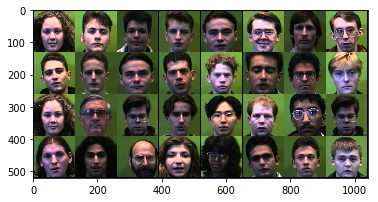

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.grid(False)
    plt.show()


dataiter = iter(dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:

criterion = nn.MSELoss()

lr = 0.0001

optimizerA = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [0]:
epochs = 50
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        if i<len(dataloader)-1:
            autoencoder.zero_grad()

            real_cpu = data[0].to(device)
        #     print(autoencoder(real_cpu))
            #imshow(torchvision.utils.make_grid(real_cpu))
            out, vec = autoencoder(real_cpu)
#             print(out.shape)
            #imshow(torchvision.utils.make_grid(out.detach()))
    
            loss = criterion(out, real_cpu)

            loss.backward()
            optimizerA.step()

            if i%50 == 0 or i==len(dataloader)-2:
                print('[%d/%d][%d/%d]\t loss: %0.3f\t' % (epoch, epochs, i, len(dataloader), loss.item()))
                imshow(torchvision.utils.make_grid(out.cpu().detach()))
#                 print(out.cpu())
#             break


In [0]:
# #saving checkpoint

# import shutil
# def save_checkpoint(state, is_best, filename='/content/drive/My Drive/Colab Notebooks/checkpointA.pth.tar'):
#     torch.save(state, filename)
# #     if is_best:
# #         shutil.copyfile(filename, 'model_bestG.pth.tar')
        
# save_checkpoint({
#             'state_dict': autoencoder.state_dict(),
#             'optimizer' : optimizerA.state_dict(),
#         }, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


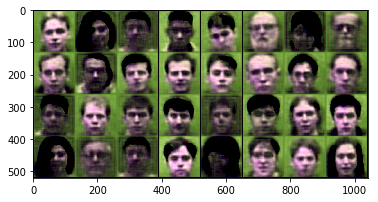

In [23]:
#modal testing
autoencoder.eval()
for i, data in enumerate(dataloader, 0):
  real_cpu = data[0].to(device)
  out, vec = autoencoder(real_cpu)
  for v, cl in zip(vec.detach().cpu(), data[1]):
    v = np.append(v, classes[cl.item()])
    writer = csv.writer(csvFile)
    writer.writerow(v)
  imshow(torchvision.utils.make_grid(out.cpu().detach()))
  
csvFile.close()

In [0]:
#loading checkpoint

checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/checkpointA.pth.tar")
autoencoder.load_state_dict(checkpoint['state_dict'])
optimizerA.load_state_dict(checkpoint['optimizer'])